# Importation des librairies et données d'entraînement

Importations

In [1]:
import tables
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from cycler import cycler
from sklearn.decomposition import PCA
#import pandas as pd

/home/forcionelaa/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#GL: nice little package to have interactive plots to zoom in etc. No need to use plt.show() as well !
%matplotlib notebook

Défintion des variables d'entraînement

In [3]:
nb_neurones = 7
backprop_len = 12
nb_batches = 300
nb_epochs = 30000

Chargement des données pour entraînement et test

In [4]:
input_file = tables.open_file('/opt/DATA/train_test_arrays.h5', mode='r')

table = input_file.root.test_array
x_test_array = table.read()['x']
y_test_array = table.read()['y']

train_array_table = input_file.root.train_array

if (backprop_len*nb_batches*nb_epochs)>train_array_table.nrows:
    print('Warning: Number of data requested larger than available data points. Train array will loop on available data.')

indexes = [[(i*nb_epochs*backprop_len+j*backprop_len)%(train_array_table.nrows-backprop_len) for i in range(nb_batches)] for j in range(nb_epochs)]

# Entraînement du réseau

In [5]:
random_seed = 0
time_delay = 0

Ouverture du fichier pour sauvegarde des résultats

In [6]:
#output_file = tables.open_file('/opt/DATA/RNN.h5', mode='w', title='RNN training progression, test data and final weights')
#output_file = tables.open_file('/opt/DATA/RNN.h5', mode='a')
#for group in output_file.walk_groups():
#    print(group)

In [7]:
#if '/RNN_seed_'+str(random_seed)+'_delay_'+str(time_delay) in output_file:
#    output_file.remove_node('/RNN_seed_'+str(random_seed)+'_delay_'+str(time_delay),recursive=True)

In [8]:
#group = output_file.create_group('/', 'RNN_seed_'+str(random_seed)+'_delay_'+str(time_delay), 'Training and testing data for RNN with random seed='+str(random_seed)+' and delay='+str(time_delay))
#group._f_setattr('random_seed',random_seed)
#group._f_setattr('time_delay',time_delay)
#group._f_setattr('nb_neurones',nb_neurones)
#group._f_setattr('backprop_len',backprop_len)
#group._f_setattr('nb_batches',nb_batches)
#group._f_setattr('nb_epochs',nb_epochs)

Architecture du réseau

In [9]:
np.random.seed(random_seed)
win = tf.constant(np.random.uniform(-np.sqrt(1./3), np.sqrt(1./3), (3, nb_neurones)), dtype=tf.float64)
#win = tf.Variable(np.random.uniform(-np.sqrt(1./3), np.sqrt(1./3), (3, nb_neurones)), dtype=tf.float64)
w = tf.Variable(np.random.uniform(-np.sqrt(1./nb_neurones), np.sqrt(1./nb_neurones), (nb_neurones, nb_neurones)), dtype=tf.float64)
wout = tf.Variable(np.random.uniform(-np.sqrt(1./nb_neurones), np.sqrt(1./nb_neurones), (nb_neurones, 3)), dtype=tf.float64)

Architecture pour entraînement

In [10]:
x_train = tf.placeholder(tf.float64, [backprop_len, nb_batches, 3])
y_train = tf.placeholder(tf.float64, [nb_batches, 3])
state_train_init = tf.placeholder(tf.float64, [nb_batches, nb_neurones])

x_series = tf.unstack(x_train, axis=0)
current_state_train = state_train_init
for current_input in x_series:
    current_input = tf.reshape(current_input, [nb_batches, 3])
    current_state_train = tf.reshape(current_state_train, [nb_batches, nb_neurones])
    next_state_train=tf.tanh(tf.matmul(current_state_train,w)+tf.matmul(current_input,win))
    current_state_train = next_state_train

pred_y_train = tf.tanh(tf.matmul(next_state_train,wout))

In [11]:
loss = tf.reduce_sum(tf.square(tf.subtract(y_train,pred_y_train)))/nb_batches/3
train = tf.train.AdamOptimizer(learning_rate=0.005).minimize(loss)

Architecture pour test

In [12]:
x_test = tf.placeholder(tf.float64, [3,])
state_test_init = tf.placeholder(tf.float64, [1, nb_neurones])

current_input = tf.reshape(x_test, [1, 3])
current_state = tf.reshape(state_test_init, [1, nb_neurones])

next_state = tf.tanh(tf.matmul(current_state,w)+tf.matmul(current_input,win))
pred_y_test = tf.tanh(tf.matmul(next_state,wout))

Initialisation du réseau

In [13]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Entraînement du réseau

In [14]:
#class TrainDataPoint(tables.IsDescription):
#    w = tables.Float64Col((nb_neurones,nb_neurones))
#    wout = tables.Float64Col((nb_neurones,3))
#    loss = tables.Float64Col()

#train_table = output_file.create_table(group, 'training_steps', TrainDataPoint, 'progression of RNN weights and loss during training')
#train_ptr = train_table.row

In [15]:
rnn_state = np.random.rand(nb_batches, nb_neurones)
nb_small_loss = 0
loss_array = []

for epoch_index in range(nb_epochs):
    
    _train = np.array([train_array_table.read(start=i,stop=i+backprop_len) for i in indexes[epoch_index]]).swapaxes(0,1)
    _x_train = _train['x']
    _y_train = _train['y'][backprop_len-time_delay-1,:]
    
    _state, _loss, _train, _w, _wout = sess.run(
        [current_state_train,loss,train,w,wout],
        feed_dict = {
            x_train : _x_train,
            y_train : _y_train,
            state_train_init : rnn_state
        })
    
    rnn_state = _state
    
    if _loss < 0.01:
        nb_small_loss += 1
    else:
        nb_small_loss = 0

    if nb_small_loss >= 200:
        break
    
    loss_array.append(_loss)
    
    if (epoch_index)%100 == 0:
#        train_ptr['w'] = _w
#        train_ptr['wout'] = _wout
#        train_ptr['loss'] = _loss
#        train_ptr.append()
#        train_table.flush()
        print('Epoch '+str(epoch_index))

#table.flush()

loss_array = np.array(loss_array)

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 2100
Epoch 2200
Epoch 2300
Epoch 2400
Epoch 2500
Epoch 2600
Epoch 2700
Epoch 2800
Epoch 2900
Epoch 3000
Epoch 3100
Epoch 3200
Epoch 3300
Epoch 3400
Epoch 3500
Epoch 3600
Epoch 3700
Epoch 3800
Epoch 3900
Epoch 4000
Epoch 4100
Epoch 4200
Epoch 4300
Epoch 4400
Epoch 4500
Epoch 4600
Epoch 4700
Epoch 4800
Epoch 4900
Epoch 5000
Epoch 5100
Epoch 5200
Epoch 5300
Epoch 5400
Epoch 5500
Epoch 5600
Epoch 5700
Epoch 5800
Epoch 5900
Epoch 6000
Epoch 6100
Epoch 6200
Epoch 6300
Epoch 6400
Epoch 6500
Epoch 6600
Epoch 6700
Epoch 6800
Epoch 6900
Epoch 7000
Epoch 7100
Epoch 7200
Epoch 7300
Epoch 7400
Epoch 7500
Epoch 7600
Epoch 7700
Epoch 7800
Epoch 7900
Epoch 8000
Epoch 8100
Epoch 8200
Epoch 8300
Epoch 8400
Epoch 8500
Epoch 8600
Epoch 8700
Epoch 8800
Epoch 8900
Epoch 9000
Epoch 9100


<IPython.core.display.Javascript object>


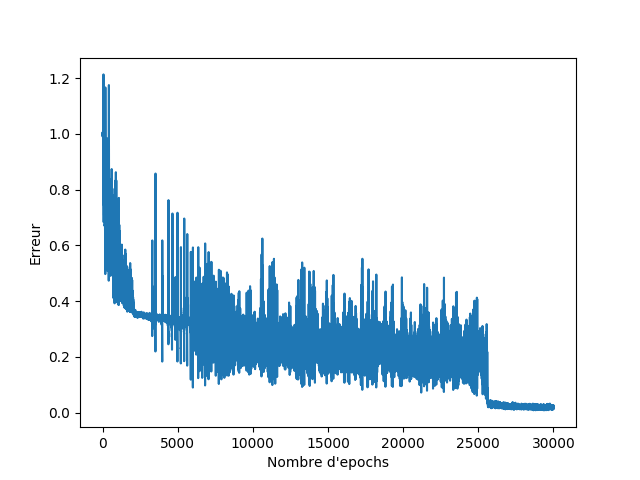

In [16]:
plt.figure()
plt.subplot(1,1,1)
plt.xlabel("Nombre d'epochs")
plt.ylabel("Erreur")
plt.plot(loss_array)

Test du réseau

In [17]:
#class TestDataPoint(tables.IsDescription):
#    states = tables.Float64Col(nb_neurones)
#    output = tables.Float64Col(3)

#test_table = output_file.create_table(group, 'testing_results', TestDataPoint, 'results of testing')
#test_ptr = test_table.row

#class FinalWeights(tables.IsDescription):
#    win = tables.Float64Col((3,nb_neurones))
#    w = tables.Float64Col((nb_neurones,nb_neurones))
#    wout = tables.Float64Col((nb_neurones,3))

#weights_table = output_file.create_table(group, 'final_weights', FinalWeights, 'final state of RNN')
#weights_ptr = weights_table.row

rnn_state = np.random.rand(1,nb_neurones)
output_array_test = []
states_array_test = []

for i in range(len(x_test_array)):
    _output, rnn_state, _w, _win, _wout = sess.run(
            [pred_y_test, next_state, w, win, wout],
            feed_dict = {
                x_test : x_test_array[i,:],
                state_test_init : rnn_state
            })
    output_array_test.append(_output[0])
    states_array_test.append(rnn_state[0])
#    test_ptr['output'] = _output
#    test_ptr['states'] = rnn_state
#    test_ptr.append()

#weights_ptr['win'] = _win
#weights_ptr['w'] = _w
#weights_ptr['wout'] = _wout
#weights_ptr.append()

#test_table.flush()
#weights_table.flush()

output_array_test = np.array(output_array_test)
states_array_test = np.array(states_array_test)

Affichage des résultats du test

<IPython.core.display.Javascript object>


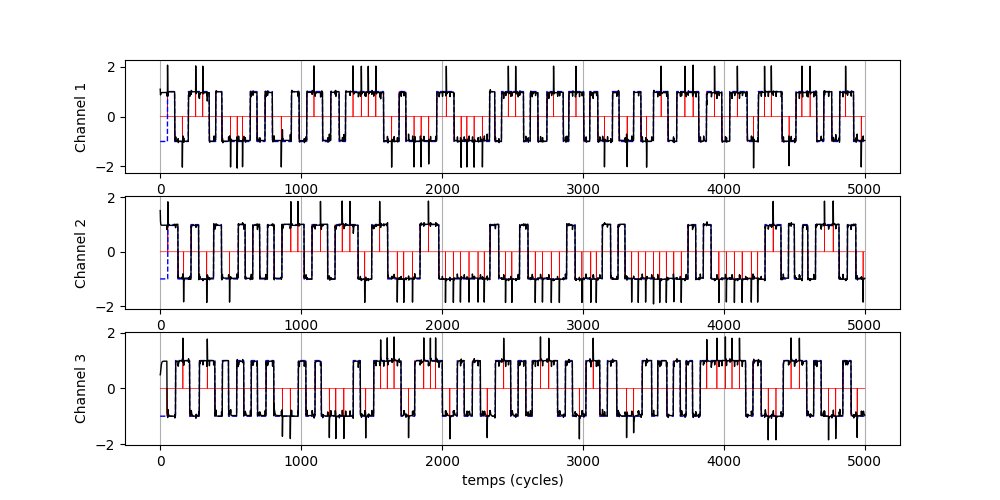

Text(0.5,0,'temps (cycles)')

In [18]:
#output_array_test = test_table.read()['output']
nb = 5000

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (10,5))

ax1.plot(np.arange(nb),x_test_array[:nb,0],'r',linewidth=0.5)
ax1.plot(np.arange(time_delay,nb),y_test_array[:nb-time_delay,0],'b--',linewidth=1)
ax1.plot(np.arange(nb),output_array_test[:nb,0],'k',linewidth=1)
ax1.xaxis.grid()
ax1.set_ylabel("Channel 1")

ax2.plot(np.arange(nb),x_test_array[:nb,1],'r',linewidth=0.5)
ax2.plot(np.arange(time_delay,nb),y_test_array[:nb-time_delay,1],'b--',linewidth=1)
ax2.plot(np.arange(nb),output_array_test[:nb,1],'k',linewidth=1)
ax2.xaxis.grid()
ax2.set_ylabel("Channel 2")

ax3.plot(np.arange(nb),x_test_array[:nb,2],'r',linewidth=0.5)
ax3.plot(np.arange(time_delay,nb),y_test_array[:nb-time_delay,2],'b--',linewidth=1)
ax3.plot(np.arange(nb),output_array_test[:nb,2],'k',linewidth=1)
ax3.xaxis.grid()
ax3.set_ylabel("Channel 3")

plt.xlabel("temps (cycles)")

Fermeture du fichier des résultats

In [19]:
#input_file.close()
#output_file.close()